In [ ]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from lib import *

In [ ]:
#@njit
def Q_func_wolfphc(p_curr_idx, s_curr_idx, r_t, alpha, discfactor, Q_table, price_grid, s_next) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        r_t: reward for player i in period t+1
        alpha: step-size parameter
        delta: discount factor
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0] 
    maxed_Q = max(Q_table[:, s_next_index])
    return prev_est+ alpha*(r_t + discfactor**2 * maxed_Q - prev_est)


def select_price_wolf(Q,current_s,epsilon,price_grid,policy):
    # Exploration
    u= np.random.uniform(0,1)
    if u < epsilon:
        return np.random.choice(price_grid)
    else:
    # Exploitation
        cumsum = np.cumsum(policy[np.where(price_grid == current_s)[0][0], :])
        idx = np.searchsorted(cumsum, np.array([u]))[0]
        return price_grid[idx - 1]
    
    
    
    


In [ ]:
#@njit
def WoLF_PHC(alpha, T, price_grid, discfactor):
    """
    args:
        alpha: step-size parameter
        delta: discount factor
        T: learning duration
        price_grid: price_grid
    returns:
        p_table: 2x500.000 array, with all prices set by player 0 and 1
        avg_profs0: player 0 list of average profit for each 1000 period
        avg_profs1: player 1 list of average profit for each 1000 period
    """
    
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    #Initializing policies 1/|A|
    policy_1 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    policy_2 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    avg_policy_1 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    avg_policy_2 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    #counters for when a state is visited
    N_1 = np.zeros(len(price_grid))
    N_2 = np.zeros(len(price_grid))


    # Setting prices for players in first 2 periods 
    p_table[i, t] = np.random.choice(price_grid) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(price_grid) # firm 2 sets price
    p_table[i, t] = p_table[i, t-1]
    t += 1 # now t = 2

    for t in range(t, T):
        p_it_idx = np.where(price_grid == p_table[i, t-2])[0][0]
        s_t_idx =  np.where(price_grid == p_table[j, t-2])[0][0]
        #Q,current_s,epsilon,price_grid,policy
        s_next = select_price_wolf(q2,p_table[i,t-1],epsilon[t], price_grid,policy_2)
        

        #step 2
        r_t=profit(p_table[i,t],p_table[j,t])+discfactor*(s_next)

        #step 3
        q1[p_it_idx, s_t_idx] = Q_func_wolfphc(p_it_idx, s_t_idx, r_t, alpha, discfactor, q1, price_grid, s_next)
        
        #step 4
        N_1[s_t_idx] += 1
        avg_policy_1[s_t_idx, :] = avg_policy_1[s_t_idx, :] + (1 / N_1[s_t_idx]) * (policy_1[s_t_idx, :] - avg_policy_1[s_t_idx, :])
        #avg_policy_1[s_t_idx, :] /= avg_policy_1[s_t_idx, :].sum() # To ensure a legal probability distribution
        if np.isclose(avg_policy_1[s_t_idx, :].sum(), 0, atol=1e-8):
            avg_policy_1[s_t_idx, :] = np.ones(len(price_grid)) / len(price_grid)
        else:
            avg_policy_1[s_t_idx, :] /= avg_policy_1[s_t_idx, :].sum()
        #step 5
        if np.sum(q1[s_t_idx, :] * policy_1[s_t_idx, :]) > np.sum(q1[s_t_idx, :] * avg_policy_1[s_t_idx, :]):
            delta = 0.2 #delta_w
        else:
            delta = 0.6 #delta_l
            #Q,current_s,epsilon,price_grid,policy
        a_prime=select_price_wolf(q1, p_table[j,t-1], epsilon[t],price_grid,policy_1)
        a_prime_idx=np.where(price_grid == a_prime)[0][0]
        if price_grid[p_it_idx] == np.argmax(q1[s_t_idx, a_prime_idx]):
            policy_1[s_t_idx,p_it_idx]+= delta
        else:
            policy_1[s_t_idx,p_it_idx]+= - delta/(len(price_grid)-1) 
        
        
        p_table[i, t] = a_prime
        p_table[j, t] = p_table[j, t-1]

        # Store profits for both firms
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        tmp=policy_1
        policy_1=policy_2
        policy_2=tmp
        tmp=N_1
        N_1=N_2
        N_2=tmp
        tmp=avg_policy_1
        avg_policy_1=avg_policy_2
        avg_policy_2=tmp
        
    return q1,q2, p_table, avg_profs1, avg_profs2


In [ ]:
qu1, qu2, p_tab, avg_profs1, avg_profs2=WoLF_PHC(0.3, 500000, np.linspace(0,1,7), 0.95)

In [14]:
print(qu1)

[[9.63412874 9.72284847 9.72484617 9.69401517 9.72836741 9.72179129
  9.74358949]
 [9.72147225 9.69195501 9.714946   9.47773411 9.51739793 9.54035611
  9.74345709]
 [9.70970338 9.69626236 9.59995541 9.6834152  9.72912691 9.70614754
  9.74312565]
 [9.63090231 9.60211593 9.68179154 9.69699284 9.63794261 9.62285461
  9.74358974]
 [9.68252298 9.70983391 9.66316696 9.70754774 9.64489271 9.72026646
  9.74358974]
 [9.7163378  9.7142879  9.72965079 9.66712465 9.58225929 9.64221124
  9.74358974]
 [9.74358974 9.74358974 9.74358974 9.74358974 9.74358974 9.74358974
  9.74358974]]


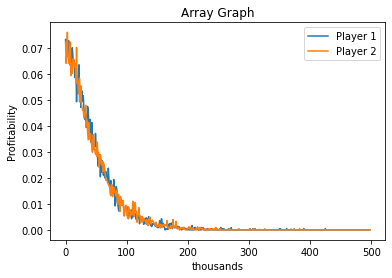

In [15]:
x_values = range(len(avg_profs1))

# Plot the array as a line graph
plt.plot(x_values, avg_profs1)
plt.plot(x_values, avg_profs2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [7]:
import numpy as np

def Q_func_wolfphc(p_curr_idx, s_curr_idx, r_t, alpha, discfactor, Q_table, price_grid, s_next) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        r_t: reward for player i in period t+1
        alpha: step-size parameter
        delta: discount factor
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0] 
    maxed_Q = max(Q_table[:, s_next_index])
    return prev_est+ alpha*(r_t + discfactor**2 * maxed_Q - prev_est)

def update_policy(policy, avg_policy, q_values, delta):
    return avg_policy + delta * (policy - avg_policy) * q_values


def select_price(player_idx, t, p_table, q, price_grid, epsilon_t):
    if np.random.random() < epsilon_t:
        return np.random.choice(price_grid)
    else:
        return price_grid[np.argmax(q[np.where(price_grid == p_table[player_idx, t-2])[0][0], :])]

def WoLF_PHC(alpha, T, price_grid, discfactor):
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 
    
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    policy_1 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    avg_policy_1 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    N_1 = np.zeros(len(price_grid))

    p_table[i, t] = np.random.choice(price_grid)
    t += 1
    p_table[j, t] = np.random.choice(price_grid)
    p_table[i, t] = p_table[i, t-1]
    t += 1

    for t in range(t, T):
        
        p_it_idx = np.where(price_grid == p_table[i, t-2])[0][0]
        s_t_idx =  np.where(price_grid == p_table[j, t-2])[0][0]
        s_next = select_price(i, t, p_table, q2, price_grid, epsilon[t])

        r_t = profit(p_table[i,t],p_table[j,t]) + discfactor * s_next

        q1[p_it_idx, s_t_idx] = Q_func_wolfphc(p_it_idx, s_t_idx, r_t, alpha, discfactor, q1, price_grid, s_next)

        N_1[s_t_idx] += 1
        avg_policy_1[s_t_idx, :] = avg_policy_1[s_t_idx, :] + (1 / N_1[s_t_idx]) * (policy_1[s_t_idx, :] - avg_policy_1[s_t_idx, :])
        #avg_policy_1[s_t_idx, :] /= avg_policy_1[s_t_idx, :].sum()
        if np.isclose(avg_policy_1[s_t_idx, :].sum(), 0, atol=1e-8):
            avg_policy_1[s_t_idx, :] = np.ones(len(price_grid)) / len(price_grid)
        else:
            avg_policy_1[s_t_idx, :] /= avg_policy_1[s_t_idx, :].sum()

        if np.sum(q1[s_t_idx, :] * policy_1[s_t_idx, :]) > np.sum(q1[s_t_idx, :] * avg_policy_1[s_t_idx, :]):
            delta = 0.2
        else:
            delta = 0.6

        a_prime = select_price(j, t, p_table, q1, price_grid, epsilon[t])
        a_prime_idx = np.where(price_grid == a_prime)[0][0]
        if price_grid[p_it_idx] == np.argmax(q1[s_t_idx, a_prime_idx]):
            policy_1[s_t_idx,p_it_idx] += delta
        else:
            policy_1[s_t_idx,p_it_idx] -= delta / (len(price_grid) - 1)
        policy_1 = update_policy(policy_1, avg_policy_1, q1, delta)
        p_table[i, t] = a_prime
        p_table[j, t] = p_table[j, t-1]

        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t]) / 1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t]) / 1000
            avg_profs2.append(profitability)

        i, j = j, i
        q1, q2 = q2, q1
        policy_1, avg_policy_1 = avg_policy_1, policy_1
        N_1 = np.zeros(len(price_grid))

    return p_table, avg_profs1, avg_profs2

# Example usage:
alpha = 0.3
T = 500000
price_grid = np.linspace(0,1,7)  # Example price grid from 1 to 100
discfactor = 0.95

p_table, avg_profs1, avg_profs2 = WoLF_PHC(alpha, T, price_grid, discfactor)
print("Average profits for Player 1:", avg_profs1)
print("Average profits for Player 2:", avg_profs2)


/var/folders/gr/gsfm7155227gh8vpmf4v3g840000gn/T/ipykernel_94887/2628097505.py:24: RuntimeWarning: overflow encountered in multiply
  return avg_policy + delta * (policy - avg_policy) * q_values
/var/folders/gr/gsfm7155227gh8vpmf4v3g840000gn/T/ipykernel_94887/2628097505.py:67: RuntimeWarning: invalid value encountered in add
  avg_policy_1[s_t_idx, :] = avg_policy_1[s_t_idx, :] + (1 / N_1[s_t_idx]) * (policy_1[s_t_idx, :] - avg_policy_1[s_t_idx, :])
/var/folders/gr/gsfm7155227gh8vpmf4v3g840000gn/T/ipykernel_94887/2628097505.py:74: RuntimeWarning: overflow encountered in multiply
  if np.sum(q1[s_t_idx, :] * policy_1[s_t_idx, :]) > np.sum(q1[s_t_idx, :] * avg_policy_1[s_t_idx, :]):
/var/folders/gr/gsfm7155227gh8vpmf4v3g840000gn/T/ipykernel_94887/2628097505.py:24: RuntimeWarning: invalid value encountered in add
  return avg_policy + delta * (policy - avg_policy) * q_values


Average profits for Player 1: [0.06540277777777778, 0.07640277777777779, 0.06788888888888889, 0.07115277777777779, 0.07484722222222223, 0.0677638888888889, 0.08123611111111112, 0.06519444444444444, 0.07151388888888889, 0.07256944444444445, 0.06927777777777777, 0.07852777777777777, 0.06197222222222223, 0.07330555555555555, 0.07033333333333334, 0.07243055555555555, 0.07370833333333335, 0.06109722222222222, 0.07293055555555555, 0.06484722222222222, 0.08516666666666668, 0.0677638888888889, 0.081375, 0.09834722222222222, 0.06148611111111112, 0.08493055555555556, 0.079375, 0.054000000000000006, 0.08201388888888889, 0.060222222222222226, 0.08165277777777778, 0.07491666666666667, 0.05483333333333333, 0.08752777777777779, 0.08376388888888889, 0.07586111111111112, 0.06373611111111112, 0.08090277777777778, 0.05701388888888889, 0.07268055555555555, 0.05590277777777778, 0.08788888888888889, 0.069125, 0.04847222222222223, 0.05618055555555556, 0.07065277777777777, 0.06479166666666668, 0.0687777777777

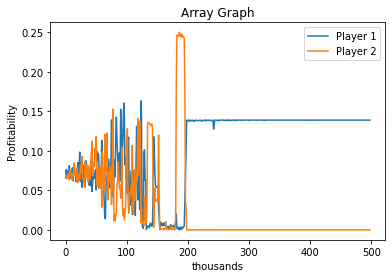

In [8]:
x_values = range(len(avg_profs1))

# Plot the array as a line graph
plt.plot(x_values, avg_profs1)
plt.plot(x_values, avg_profs2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [9]:
def update_policy(policy, avg_policy, q_values, delta):
    updated_policy = avg_policy + delta * (policy - avg_policy) * q_values
    updated_policy = np.clip(updated_policy, 0, 1)  # Clip values to the range [0, 1]
    return updated_policy

def WoLF_PHC(alpha, T, price_grid, discfactor):
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 
    
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    policy_1 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    avg_policy_1 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    N_1 = np.zeros(len(price_grid))

    p_table[i, t] = np.random.choice(price_grid)
    t += 1
    p_table[j, t] = np.random.choice(price_grid)
    p_table[i, t] = p_table[i, t-1]
    t += 1

    for t in range(t, T):
        
        p_it_idx = np.where(price_grid == p_table[i, t-2])[0][0]
        s_t_idx =  np.where(price_grid == p_table[j, t-2])[0][0]
        s_next = select_price(i, t, p_table, q2, price_grid, epsilon[t])

        r_t = profit(p_table[i,t],p_table[j,t]) + discfactor * s_next

        q1[p_it_idx, s_t_idx] = Q_func_wolfphc(p_it_idx, s_t_idx, r_t, alpha, discfactor, q1, price_grid, s_next)

        N_1[s_t_idx] += 1
        avg_policy_1[s_t_idx, :] = avg_policy_1[s_t_idx, :] + (1 / (N_1[s_t_idx] + 1e-9)) * (policy_1[s_t_idx, :] - avg_policy_1[s_t_idx, :])
        avg_policy_1[s_t_idx, :] /= np.sum(avg_policy_1[s_t_idx, :]) + 1e-9  # Ensure a valid probability distribution
        
        if np.sum(q1[s_t_idx, :] * policy_1[s_t_idx, :]) > np.sum(q1[s_t_idx, :] * avg_policy_1[s_t_idx, :]):
            delta = 0.2
        else:
            delta = 0.6

        a_prime = select_price(j, t, p_table, q1, price_grid, epsilon[t])
        a_prime_idx = np.where(price_grid == a_prime)[0][0]
        if price_grid[p_it_idx] == np.argmax(q1[s_t_idx, a_prime_idx]):
            policy_1[s_t_idx,p_it_idx] += delta
        else:
            policy_1[s_t_idx,p_it_idx] -= delta / (len(price_grid) - 1)
        
        policy_1 = update_policy(policy_1, avg_policy_1, q1, delta)
        
        p_table[i, t] = a_prime
        p_table[j, t] = p_table[j, t-1]

        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t]) / 1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t]) / 1000
            avg_profs2.append(profitability)

        i, j = j, i
        q1, q2 = q2, q1
        N_1 = np.zeros(len(price_grid))

    return p_table, avg_profs1, avg_profs2

# Example usage:
alpha = 0.3
T = 500000
price_grid = np.linspace(0,1,7)  # Example price grid from 0 to 1
discfactor = 0.95

p_table, avg_profs1, avg_profs2 = WoLF_PHC(alpha, T, price_grid, discfactor)
print("Average profits for Player 1:", avg_profs1)
print("Average profits for Player 2:", avg_profs2)


Average profits for Player 1: [0.07197222222222223, 0.06656944444444446, 0.06643055555555558, 0.06815277777777777, 0.06519444444444446, 0.07298611111111111, 0.07890277777777778, 0.06397222222222222, 0.07415277777777779, 0.062027777777777786, 0.06379166666666668, 0.06648611111111112, 0.06216666666666667, 0.06840277777777777, 0.08294444444444446, 0.07959722222222222, 0.06698611111111111, 0.06448611111111112, 0.07029166666666667, 0.07725, 0.06854166666666667, 0.06606944444444446, 0.06231944444444445, 0.06229166666666667, 0.07068055555555554, 0.09666666666666665, 0.06258333333333332, 0.07822222222222223, 0.07118055555555555, 0.08791666666666667, 0.053902777777777786, 0.07568055555555557, 0.07269444444444445, 0.06184722222222222, 0.05588888888888889, 0.04229166666666667, 0.07983333333333334, 0.09822222222222222, 0.08476388888888889, 0.058208333333333334, 0.04973611111111111, 0.07619444444444445, 0.08233333333333334, 0.023694444444444445, 0.061402777777777785, 0.06620833333333334, 0.03888888

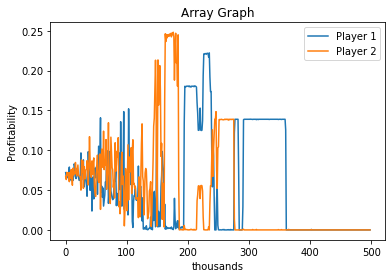

In [10]:
x_values = range(len(avg_profs1))

# Plot the array as a line graph
plt.plot(x_values, avg_profs1)
plt.plot(x_values, avg_profs2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [11]:
done = True
while done:
    a, b, c = WoLF_PHC(alpha, T, price_grid, discfactor)
    if abs(b[498] - c[498]) < 0.001 and abs(b[497] - c[497]) < 0.001 : 
        done = False

In [6]:
def environment_response(state, action):
    # This function should return the next state and reward after taking an action in a given state.
    # Implement according to your environment's dynamics.
    next_state = state  # Placeholder
    reward = 0  # Placeholder
    return next_state, reward

In [ ]:
#@njit
def WoLF_PHC(alpha, T, price_grid, discfactor):
    """
    args:
        alpha: step-size parameter
        delta: discount factor
        T: learning duration
        price_grid: price_grid
    returns:
        p_table: 2x500.000 array, with all prices set by player 0 and 1
        avg_profs0: player 0 list of average profit for each 1000 period
        avg_profs1: player 1 list of average profit for each 1000 period
    """
    
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    #Initializing policies 1/|A|
    policy_1 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    policy_2 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    avg_policy_1 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    avg_policy_2 = np.ones((len(price_grid), len(price_grid))) / len(price_grid)
    #counters for when a state is visited
    N_1 = np.zeros(len(price_grid))
    N_2 = np.zeros(len(price_grid))


    # Setting prices for players in first 2 periods 
    p_table[i, t] = np.random.choice(price_grid) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(price_grid) # firm 2 sets price
    p_table[i, t] = p_table[i, t-1]
    t += 1 # now t = 2

    for t in range(t, T):
        p_it_idx = np.where(price_grid == p_table[i, t-2])[0][0]
        state_idx =  np.where(price_grid == p_table[j, t-2])[0][0]
        #Q,current_s,epsilon,price_grid,policy
        action=select_price(price_grid, policy_1[state_idx])
        next_state, reward = environment_response(state, action)
        s_next = select_price_wolf(q2,p_table[i,t-1],epsilon[t], price_grid,policy_2)
        

        #step 2
        r_t=profit(p_table[i,t],p_table[j,t])+discfactor*(s_next)

        #step 3
        q1[p_it_idx, s_t_idx] = Q_func_wolfphc(p_it_idx, s_t_idx, r_t, alpha, discfactor, q1, price_grid, s_next)
        
        #step 4
        N_1[s_t_idx] += 1
        avg_policy_1[s_t_idx, :] = avg_policy_1[s_t_idx, :] + (1 / N_1[s_t_idx]) * (policy_1[s_t_idx, :] - avg_policy_1[s_t_idx, :])
        #avg_policy_1[s_t_idx, :] /= avg_policy_1[s_t_idx, :].sum() # To ensure a legal probability distribution
        if np.isclose(avg_policy_1[s_t_idx, :].sum(), 0, atol=1e-8):
            avg_policy_1[s_t_idx, :] = np.ones(len(price_grid)) / len(price_grid)
        else:
            avg_policy_1[s_t_idx, :] /= avg_policy_1[s_t_idx, :].sum()
        #step 5
        if np.sum(q1[s_t_idx, :] * policy_1[s_t_idx, :]) > np.sum(q1[s_t_idx, :] * avg_policy_1[s_t_idx, :]):
            delta = 0.2 #delta_w
        else:
            delta = 0.6 #delta_l
            #Q,current_s,epsilon,price_grid,policy
        a_prime=select_price_wolf(q1, p_table[j,t-1], epsilon[t],price_grid,policy_1)
        a_prime_idx=np.where(price_grid == a_prime)[0][0]
        if price_grid[p_it_idx] == np.argmax(q1[s_t_idx, a_prime_idx]):
            policy_1[s_t_idx,p_it_idx]+= delta
        else:
            policy_1[s_t_idx,p_it_idx]+= - delta/(len(price_grid)-1) 
        
        
        p_table[i, t] = a_prime
        p_table[j, t] = p_table[j, t-1]

        # Store profits for both firms
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        tmp=policy_1
        policy_1=policy_2
        policy_2=tmp
        tmp=N_1
        N_1=N_2
        N_2=tmp
        tmp=avg_policy_1
        avg_policy_1=avg_policy_2
        avg_policy_2=tmp
        
    return q1,q2, p_table, avg_profs1, avg_profs2
